In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [2]:
# Code taken from https://pypi.org/project/gdown/
import gdown

In [3]:
url = "https://drive.google.com/drive/folders/15LpkCSgro5H-ZzbARRVw7cT23sz3cPGC?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/project/ModelEnsemle.ipynb',
 '/content/project/movies_classification_updated.csv',
 '/content/project/movies_classification.csv',
 '/content/project/movies_metadata.csv',
 '/content/project/XGBoost_model.ipynb']

In [4]:
data = pd.read_csv('/content/project/movies_classification_updated.csv')
metadata = pd.read_csv('/content/project/movies_metadata.csv')

<ipython-input-4-238be40e0e7d>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/project/movies_metadata.csv')


In [5]:
#dropping data with null values since theres so few:

#null runtimes
null_runtimes = data[data['runtime'].isnull()].index.tolist()
data = data.drop(null_runtimes)

#null release info
null_dates = data[data['release_year'].isnull()].index.tolist()
data = data.drop(null_dates)

In [6]:
y=data.revenue
X= data.drop(columns=['Unnamed: 0', 'revenue', 'popularity', 'title'])

In [7]:
#splitting into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [8]:
X_test=X_test.drop(columns=['vote_average', 'vote_count'])
X_train=X_train.drop(columns=['vote_average', 'vote_count'])

In [9]:
#ensembling
#Tuned AdaBoost model from Section 7.2.4
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001).fit(X_train,y_train)
y_pred= model_ada.predict(X_test)
test_precision_ada = precision_score(y_test, y_pred)


# Tuned XGBoost model from Section 9.2.6
model_xgb = xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
test_precision_xgb = precision_score(y_test, y_pred)


# Tuned Decision tree classifier
model_dt = DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140).fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
test_precision_dt = precision_score(y_test, y_pred)

#random forest
model_rf = RandomForestClassifier(n_estimators=2000, max_features=1, min_samples_split=2, max_depth=15, max_leaf_nodes=45, random_state=1).fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
test_precision_rf = precision_score(y_test, y_pred)

#lasso
model_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1).fit(X_train, y_train)
y_pred = model_lasso.predict(X_test)
test_precision_lasso = precision_score(y_test, y_pred)


print("Adaboost model precision = ",test_precision_ada)
print("XGBoost model precision = ",test_precision_xgb)
print("Decision Tree Classifier model precision = ",test_precision_dt)
print("Random Forest Classifier model precision = ",test_precision_rf)
print("Lasso Classifier model precision = ",test_precision_lasso)


Adaboost model precision =  0.7895716945996276
XGBoost model precision =  0.7849740932642487
Decision Tree Classifier model precision =  0.7814685314685315
Random Forest Classifier model precision =  1.0
Lasso Classifier model precision =  0.8698060941828255


#MANUAL ENSEMBLING

#Adaboost

In [11]:
cross_val_ypred = cross_val_predict(AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [12]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [13]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Text(0.5, 1.0, 'Train data performance metrics')

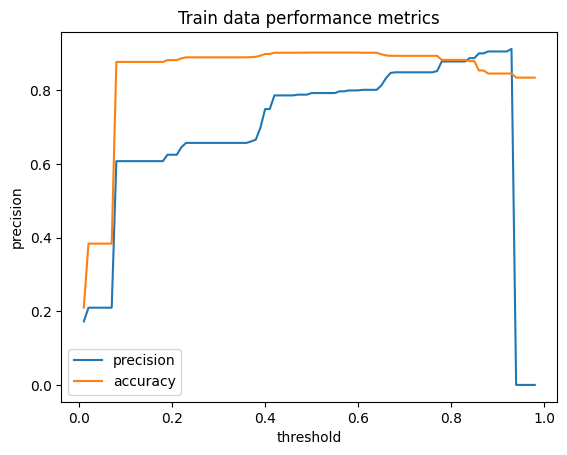

In [14]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [15]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.7,.9,0.001)

In [16]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

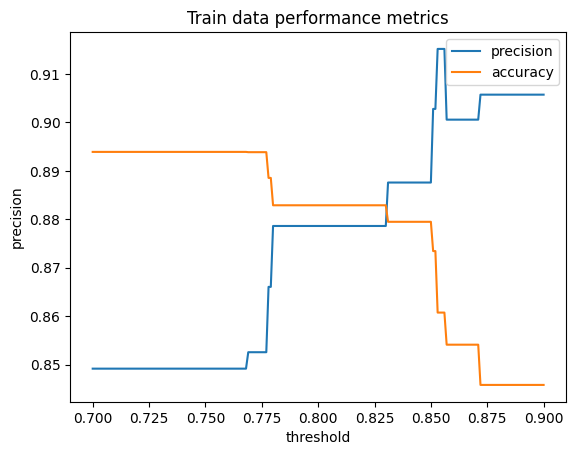

In [17]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [18]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.87].sort_values('precision', ascending=False)

,accuracy,precision,threshold
152,0.873448,0.902794,0.852
151,0.873448,0.902794,0.851
141,0.879489,0.887597,0.841
131,0.879489,0.887597,0.831
132,0.879489,0.887597,0.832
...,...,...,...
41,0.89392,0.849175,0.741
40,0.89392,0.849175,0.74
39,0.89392,0.849175,0.739
37,0.89392,0.849175,0.737


In [19]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001).fit(X_train, y_train)

In [20]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.852

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_ADA = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred_ADA, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred_ADA))

Test data performance metrics (with decision threshold of 0.849):
Accuracy:  86.26398210290827
Precision:  0.9468085106382979


#XGBoost

In [21]:
cross_val_ypred = cross_val_predict(xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [22]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [23]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

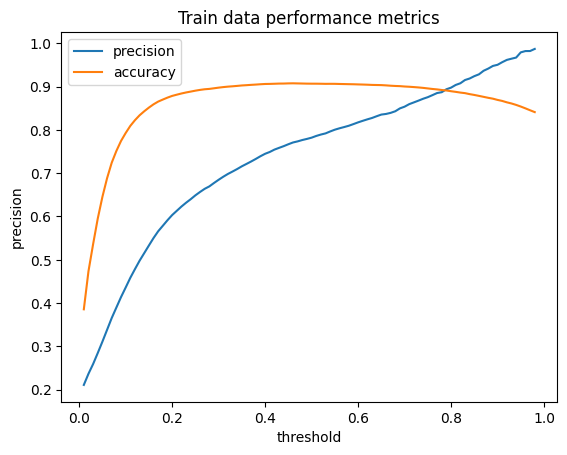

In [24]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [25]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.6,.85,0.001)

In [26]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

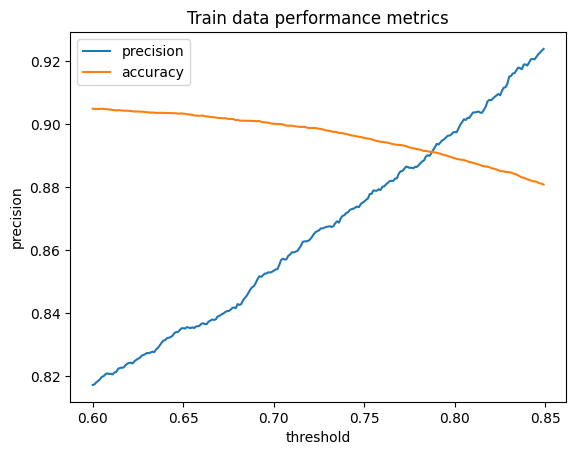

In [27]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [28]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.88].sort_values('precision', ascending=False)

,accuracy,precision,threshold
249,0.880775,0.92379,0.849
248,0.881027,0.923274,0.848
247,0.881167,0.922607,0.847
246,0.881391,0.922065,0.846
245,0.881698,0.921224,0.845
...,...,...,...
4,0.904743,0.819016,0.604
3,0.904743,0.818529,0.603
2,0.904771,0.818089,0.602
1,0.904771,0.817444,0.601


In [29]:
model = xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)

In [30]:
pd.concat([pd.Series(X_test.columns, name = 'predictor'), 
           pd.Series(model.feature_importances_, 
                     name = 'importance')], axis = 1).sort_values(by = 'importance', ascending=False)

,predictor,importance
1,budget,0.498358
23,english,0.054206
0,belongs_to_collection,0.044424
4,Comedy,0.035602
24,release_year,0.032953
22,TV Movie,0.029939
2,runtime,0.026942
9,Drama,0.025464
8,Romance,0.022840
3,Animation,0.021011


In [31]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.849

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_XGB = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred_XGB, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred_XGB))

Test data performance metrics (with decision threshold of 0.849):
Accuracy:  88.27740492170022
Precision:  0.9251968503937008


#Decision Tree

In [32]:
cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [33]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [34]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

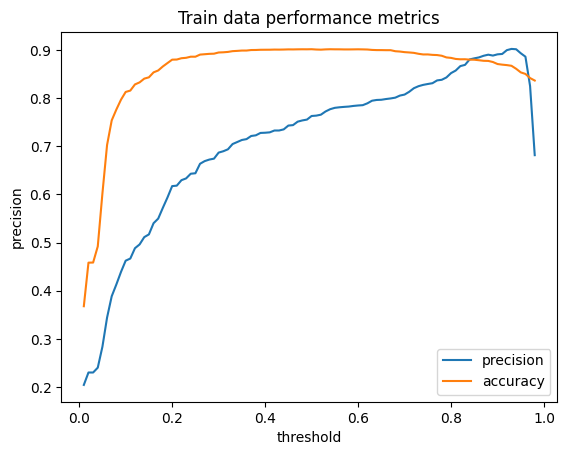

In [35]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [36]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.7,.85,0.001)

In [37]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

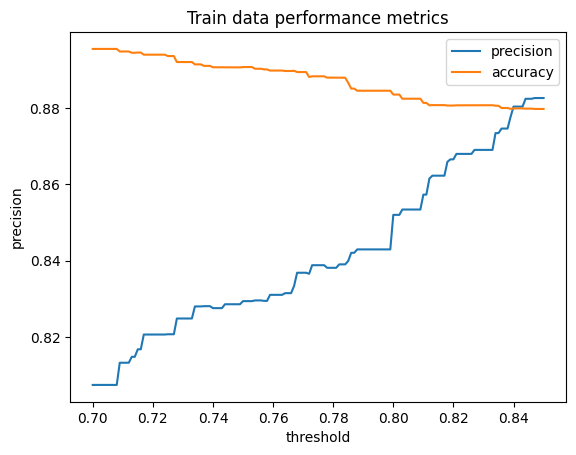

In [38]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [39]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.87].sort_values('precision', ascending=False)

,accuracy,precision,threshold
150,0.879796,0.88266,0.85
149,0.879796,0.88266,0.849
148,0.879796,0.88266,0.848
147,0.879796,0.88266,0.847
146,0.87988,0.882464,0.846
...,...,...,...
5,0.895542,0.80741,0.705
4,0.895542,0.80741,0.704
3,0.895542,0.80741,0.703
2,0.895542,0.80741,0.702


In [40]:
model = DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140).fit(X_train, y_train)

In [41]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.85

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_DT = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred_DT, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred_DT))

Test data performance metrics (with decision threshold of 0.849):
Accuracy:  88.51230425055928
Precision:  0.8939130434782608


#Random Forest

In [42]:
cross_val_ypred = cross_val_predict(RandomForestClassifier(n_estimators=2000, max_features=1, min_samples_split=2, max_depth=15, max_leaf_nodes=45, random_state=1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [43]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [44]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Text(0.5, 1.0, 'Train data performance metrics')

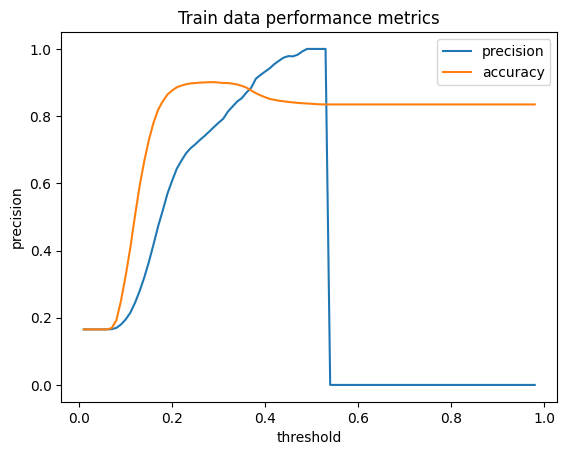

In [45]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [46]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.2,.4,0.001)

In [47]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

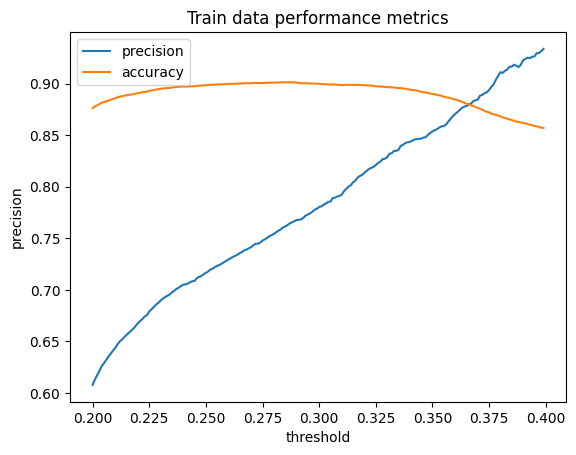

In [48]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [49]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.86].sort_values('precision', ascending=False)

,accuracy,precision,threshold
192,0.860835,0.925251,0.392
193,0.860275,0.924651,0.393
191,0.861534,0.923894,0.391
190,0.861925,0.922609,0.39
186,0.863995,0.9184,0.386
...,...,...,...
4,0.881446,0.625867,0.204
3,0.88016,0.62123,0.203
2,0.879013,0.617103,0.202
1,0.877811,0.61287,0.201


In [50]:
model = RandomForestClassifier(n_estimators=2000, max_features=1, min_samples_split=2, max_depth=15, max_leaf_nodes=45, random_state=1).fit(X_train, y_train)

In [51]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.392

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_RF = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred_RF, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred_RF))

Test data performance metrics (with decision threshold of 0.849):
Accuracy:  86.01789709172259
Precision:  0.9197080291970803


#Lasso

In [52]:
cross_val_ypred = cross_val_predict(LogisticRegression(penalty='l1', solver='liblinear', C=0.1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [53]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [54]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

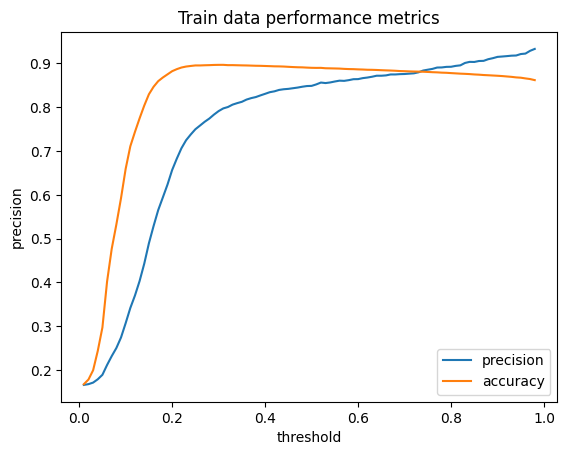

In [55]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [56]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.6,.80,0.001)

In [57]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

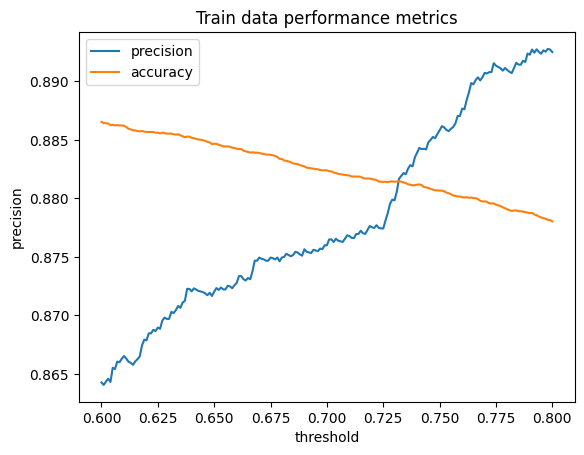

In [58]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [59]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.88].sort_values('precision', ascending=False)

,accuracy,precision,threshold
166,0.88002,0.89012,0.766
164,0.880076,0.889851,0.764
165,0.88002,0.889745,0.765
163,0.880048,0.889049,0.763
162,0.880104,0.88841,0.762
...,...,...,...
3,0.886397,0.864587,0.603
2,0.886425,0.864353,0.602
4,0.886257,0.86432,0.604
0,0.886537,0.86428,0.6


In [60]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1).fit(X_train, y_train)

In [61]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.8
y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_lasso = y_pred.astype(int)

print('Test data performance metrics:')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred))

Test data performance metrics:
Accuracy:  87.90827740492169
Precision:  0.8997995991983968


In [62]:
predictions = pd.DataFrame({'Decision Tree': y_pred_DT, 'XGBoost': y_pred_XGB, 'ADABoost': y_pred_ADA, 'Random Forest':y_pred_RF, 'Lasso': y_pred_lasso})
predictions['majority'] = predictions['Decision Tree'] + predictions.XGBoost + predictions.ADABoost + predictions['Random Forest'] + predictions['Lasso']

In [63]:
majority_predictions = []
for x in predictions.majority:
  if x > 2:
    majority_predictions.append(1)
  if x <= 2:
    majority_predictions.append(0)

In [64]:
len(majority_predictions)

8940

In [65]:
print('Test data performance metrics of ensemble:')
#Computing the am

Test data performance metrics of ensemble:
Accuracy:  87.88590604026845
Precision:  0.93058568329718
